# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [18]:
!pip install pandas_ta
!pip install PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[**********************99%***********************]  497 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-29 A        43.023453   45.639999   46.000000   45.570000   45.680000   
           AAPL     27.026245   29.182501   29.277500   29.100000   29.112499   
           ABBV     44.492252   62.730000   63.060001   62.389999   62.389999   
           ABT      33.147774   38.310001   38.509998   38.110001   38.299999   
           ACGL     28.696667   28.696667   28.809999   28.536667   28.610001   
...                       ...         ...         ...         ...         ...   
2024-12-26 XYL     118.470001  118.470001  118.720001  117.540001  117.800003   
           YUM     136.000000  136.000000  136.800003  134.199997  134.350006   
           ZBH     107.250000  107.250000  108.120003  106.610001  107.000000   
           ZBRA    396.850006  396.850006  397.500000  392.109985  392.269989   
           ZTS     165.520004  165.520004  165.789993  163.020004  163.720001   

Price                  volume  
date       ticker              
2016-12-29 A         891000.0  
           AAPL    60158000.0  
           ABBV     4990000.0  
           ABT      7050800.0  
           ACGL      731100.0  
...                       ...  
2024-12-26 XYL       575700.0  
           YUM      1040900.0  
           ZBH      1277300.0  
           ZBRA      140100.0  
           ZTS      2167200.0  

[991713 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-29 A        43.023453   45.639999   46.000000   45.570000   45.680000   
           AAPL     27.026245   29.182501   29.277500   29.100000   29.112499   
           ABBV     44.492252   62.730000   63.060001   62.389999   62.389999   
           ABT      33.147774   38.310001   38.509998   38.110001   38.299999   
           ACGL     28.696667   28.696667   28.809999   28.536667   28.610001   
...                       ...         ...         ...         ...         ...   
2024-12-26 XYL     118.470001  118.470001  118.720001  117.540001  117.800003   
           YUM     136.000000  136.000000  136.800003  134.199997  134.350006   
           ZBH     107.250000  107.250000  108.120003  106.610001  107.000000   
           ZBRA    396.850006  396.850006  397.500000  392.109985  392.269989   
           ZTS     165.520004  165.520004  165.789993  163.020004  163.720001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-12-29 A         891000.0         -0.001343        NaN       NaN   
           AAPL    60158000.0         -0.002117        NaN       NaN   
           ABBV     4990000.0         -0.044098        NaN       NaN   
           ABT      7050800.0         -0.008009        NaN       NaN   
           ACGL      731100.0          0.000042        NaN       NaN   
...                       ...               ...        ...       ...   
2024-12-26 XYL       575700.0          0.000037  38.652872  4.747645   
           YUM      1040900.0          0.000127  51.828757  4.884407   
           ZBH      1277300.0          0.000097  47.670320  4.659428   
           ZBRA      140100.0          0.000041  52.110783  5.956002   
           ZTS      2167200.0          0.000096  36.061861  5.094538   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-12-29 A            NaN       NaN       NaN       NaN      38.333896  
           AAPL         NaN       NaN       NaN       NaN    1625.844854  
           ABBV         NaN       NaN       NaN       NaN     222.016339  
           ABT          NaN       NaN       NaN       NaN     233.718323  
           ACGL         NaN       NaN       NaN       NaN      20.980133  
...                     ...       ...       ...       ...            ...  
2024-12-26 XYL     4.818183  4.888722  0.506754 -1.562754      68.203180  
           YUM     4.922677  4.960947  0.619214 -0.496232     141.562400  
           ZBH     4.694219  4.729010 -0.600698 -0.273377     136.990425  
           ZBRA    5.997550  6.039098  0.000369 -0.152269      55.598686  
           ZTS     5.157927  5.221317  0.414887 -1.639642     358.714953  

[991713 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-02-28 A           98.459298   48.358971         -0.001515  63.782422   
           AAPL      3730.196599   31.854513         -0.002049  87.859415   
           ABBV       293.042512   44.303558         -0.044025  53.224190   
           ABT        332.530647   39.257484         -0.008100  76.196390   
           ACGL        36.285420   31.523333          0.000039  76.306765   
...                          ...         ...               ...        ...   
2024-12-31 XYL        177.184578  118.470001          0.000037  38.652872   
           YUM        214.992779  136.000000          0.000127  51.828757   
           ZBH        170.860329  107.250000          0.000097  47.670320   
           ZBRA       123.775856  396.850006          0.000041  52.110783   
           ZTS        433.068024  165.520004          0.000096  36.061861   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-02-28 A       3.845834  3.883584  3.921333 -1.557997  0.293664  
           AAPL    3.400463  3.462253  3.524044 -1.456204  0.117520  
           ABBV    3.784567  3.803218  3.821869 -1.771328 -0.216258  
           ABT     3.609819  3.664647  3.719474 -1.552262  0.663475  
           ACGL    3.422038  3.460980  3.499921 -1.180559  0.355150  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.747645  4.818183  4.888722  0.506754 -1.562754  
           YUM     4.884407  4.922677  4.960947  0.619214 -0.496232  
           ZBH     4.659428  4.694219  4.729010 -0.600698 -0.273377  
           ZBRA    5.956002  5.997550  6.039098  0.000369 -0.152269  
           ZTS     5.094538  5.157927  5.221317  0.414887 -1.639642  

[46845 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388088         -0.001208  40.100766  3.695993   
           ABBV     83.089935         -0.042428  62.305766  4.236627   
           ABT      55.294991         -0.005933  69.274921  3.936873   
           ACN     144.842682         -0.003841  63.135436  4.952747   
           ADBE    199.759995          0.000156  65.801042  5.203949   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    269.380005          0.000102  53.498927  5.528268   
           WFC      71.760002          0.000044  54.118695  4.233864   
           WMT      92.790001          0.000027  58.474467  4.521093   
           XOM     106.489998          0.000052  29.035232  4.643854   
           ZTS     165.520004          0.000096  36.061861  5.094538   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-01-31 AAPL    3.736405  3.776816 -1.246528 -0.430039  
           ABBV    4.368567  4.500507  1.179613  1.689173  
           ABT     3.995678  4.054483 -0.925023  0.888200  
           ACN     4.976202  4.999656 -1.246239  0.243560  
           ADBE    5.268046  5.332143 -1.283856  0.406553  
...                     ...       ...       ...       ...  
2024-12-31 WDAY    5.592435  5.656603  1.396000  0.515571  
           WFC     4.294098  4.354333  1.477138 -0.202204  
           WMT     4.548861  4.576629  3.106098  1.711857  
           XOM     4.721047  4.798240  0.115918 -2.735609  
           ZTS     5.157927  5.221317  0.414887 -1.639642  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743031         -0.000391  53.482572  3.564609   
           ABBV     62.078800         -0.021799  41.951147  4.108503   
           ABT      66.100266         -0.001865  56.879254  4.115729   
           ACN     140.895599         -0.002769  55.082635  4.855345   
           ADBE    247.820007          0.000148  56.084696  5.412191   
...                       ...               ...        ...       ...   
2024-12-31 VZ       39.959999          0.000054  36.066858  3.685807   
           WDAY    269.380005          0.000102  53.498927  5.528268   
           WFC      71.760002          0.000044  54.118695  4.233864   
           WMT      92.790001          0.000027  58.474467  4.521093   
           XOM     106.489998          0.000052  29.035232  4.643854   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-01-31 AAPL    3.630896  3.697183 -0.865626 -0.381170   0.055154   
           ABBV    4.201370  4.294236  0.343455 -1.043382  -0.118399   
           ABT     4.161145  4.206561 -0.065967  0.139832   0.013665   
           ACN     4.915819  4.976293 -0.769556  0.043043   0.088930   
           ADBE    5.478527  5.544863 -0.672298  0.203190   0.095385   
...                     ...       ...       ...       ...        ...   
2024-12-31 VZ      3.756325  3.826842 -0.680536 -1.566520  -0.098782   
           WDAY    5.592435  5.656603  1.396000  0.515571   0.077563   
           WFC     4.294098  4.354333  1.477138 -0.202204  -0.057897   
           WMT     4.548861  4.576629  3.106098  1.711857   0.005358   
           XOM     4.721047  4.798240  0.115918 -2.735609  -0.097236   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-01-31 AAPL    -0.034588  -0.086165  -0.020933   0.001996    0.000748  
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001  
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985  
           ACN     -0.033915  -0.008682  -0.004631   0.002728   -0.002300  
           ADBE    -0.006137   0.002786   0.002128   0.012503    0.018128  
...                      ...        ...        ...        ...         ...  
2024-12-31 VZ      -0.026094  -0.033200   0.000032  -0.000117    0.010280  
           WDAY     0.073282   0.032957   0.031562  -0.001380   -0.002039  
           WFC      0.054386   0.085097   0.034336   0.026188    0.034164  
           WMT      0.065263   0.048190   0.054810   0.050300    0.049563  
           XOM     -0.045073  -0.031494  -0.011583  -0.007913    0.007397  

[10361 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV    0.0840  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10078 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV    0.0840  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN     0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE    0.0840  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10061 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VZ      0.734851 -0.727650  0.404497  0.236656  0.079245
           WDAY    1.141140 -0.823419 -0.098117 -1.510394 -0.116041
           WFC     0.938969 -0.274123  1.298547 -1.246689 -0.662802
           WMT     0.650253 -0.021232 -0.191271  1.048214  0.088267
           XOM     0.366522 -0.109620  0.369991  0.571946  0.339939

[10061 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10138 entries, (Timestamp('2019-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10138 non-null  float64
 1   rsi               10138 non-null  float64
 2   bb_low            10138 non-null  float64
 3   bb_mid            10138 non-null  float64
 4   bb_high           10138 non-null  float64
 5   atr               10138 non-null  float64
 6   macd              10138 non-null  float64
 7   return_1m         10138 non-null  float64
 8   return_2m         10138 non-null  float64
 9   return_3m         10138 non-null  float64
 10  return_6m         10138 non-null  float64
 11  return_9m         10138 non-null  float64
 12  return_12m        10138 non-null  float64
 13  Mkt-RF            10138 non-null  float64
 14  SMB               10138 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [21]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-01-31 AAPL           -0.000391  53.482572  3.564609  3.630896  3.697183   
           ABBV           -0.021799  41.951147  4.108503  4.201370  4.294236   
           ABT            -0.001865  56.879254  4.115729  4.161145  4.206561   
           ACN            -0.002769  55.082635  4.855345  4.915819  4.976293   
           ADBE            0.000148  56.084696  5.412191  5.478527  5.544863   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ              0.000054  36.066858  3.685807  3.756325  3.826842   
           WDAY            0.000102  53.498927  5.528268  5.592435  5.656603   
           WFC             0.000044  54.118695  4.233864  4.294098  4.354333   
           WMT             0.000027  58.474467  4.521093  4.548861  4.576629   
           XOM             0.000052  29.035232  4.643854  4.721047  4.798240   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-01-31 AAPL   -0.865626 -0.381170   0.055154  -0.034588  -0.086165   
           ABBV    0.343455 -1.043382  -0.118399  -0.071480   0.014454   
           ABT    -0.065967  0.139832   0.013665  -0.004952   0.020737   
           ACN    -0.769556  0.043043   0.088930  -0.033915  -0.008682   
           ADBE   -0.672298  0.203190   0.095385  -0.006137   0.002786   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ     -0.680536 -1.566520  -0.098782  -0.026094  -0.033200   
           WDAY    1.396000  0.515571   0.077563   0.073282   0.032957   
           WFC     1.477138 -0.202204  -0.057897   0.054386   0.085097   
           WMT     3.106098  1.711857   0.005358   0.065263   0.048190   
           XOM     0.115918 -2.735609  -0.097236  -0.045073  -0.031494   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-01-31 AAPL    -0.020933   0.001996    0.000748  1.291616 -0.228070   
           ABBV    -0.019116  -0.016684   -0.024001  0.542367  0.293713   
           ABT      0.019565   0.027107    0.014985  0.759528 -0.038009   
           ACN     -0.004631   0.002728   -0.002300  1.205744 -0.210162   
           ADBE     0.002128   0.012503    0.018128  1.320335 -0.573196   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ       0.000032  -0.000117    0.010280  0.466936 -0.487895   
           WDAY     0.031562  -0.001380   -0.002039  1.190146 -0.645828   
           WFC      0.034336   0.026188    0.034164  1.119773 -0.107320   
           WMT      0.054810   0.050300    0.049563  0.639577 -0.343241   
           XOM     -0.011583  -0.007913    0.007397  1.009406  0.042483   

                        HML       RMW       CMA  cluster_predefined  cluster  
date       ticker                                                             
2019-01-31 AAPL   -0.635731  0.318374  0.490113                   0        1  
           ABBV   -0.153332  0.401257  0.518834                   1        0  
           ABT    -0.436774  0.160003  0.989275                   0        3  
           ACN    -0.220807  0.366231  0.002176                   0        1  
           ADBE   -0.250410  0.315635 -0.419132                   0        3  
...                     ...       ...       ...                 ...      ...  
2024-12-31 VZ      0.308512  0.132349  0.078466                   1        1  
           WDAY   -0.390143 -0.875492 -0.289634                   0        3  
           WFC     1.592847 -0.673698 -1.007959                   0        3  
           WMT    -0.364022  0.179802  0.614317                   0        3  
           XOM     0.918402 -0.479273  0.353513                   1        1  

[10138 rows

In [22]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


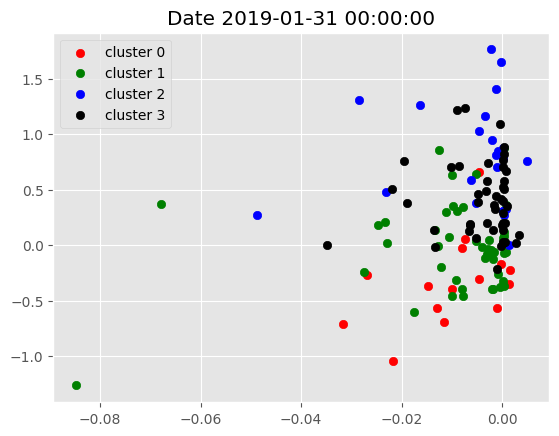

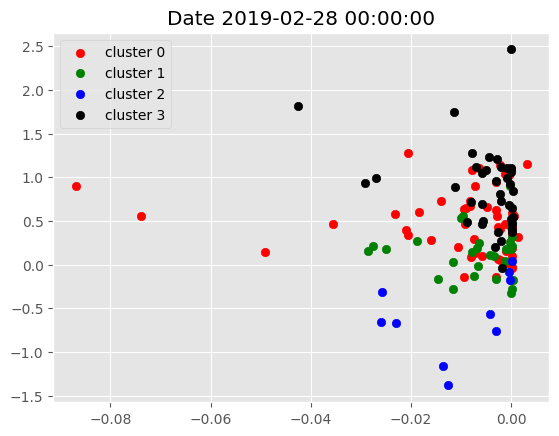

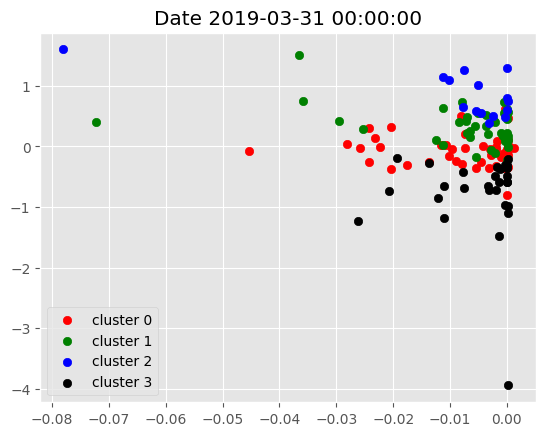

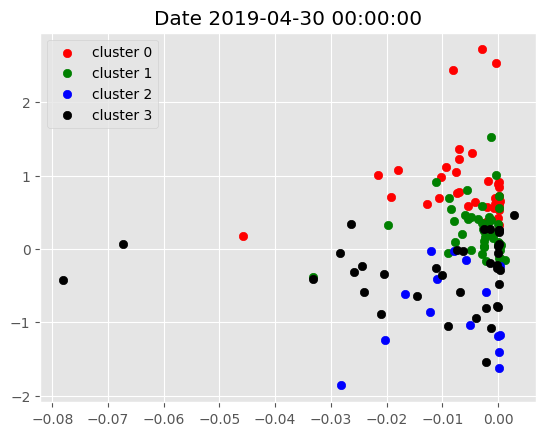

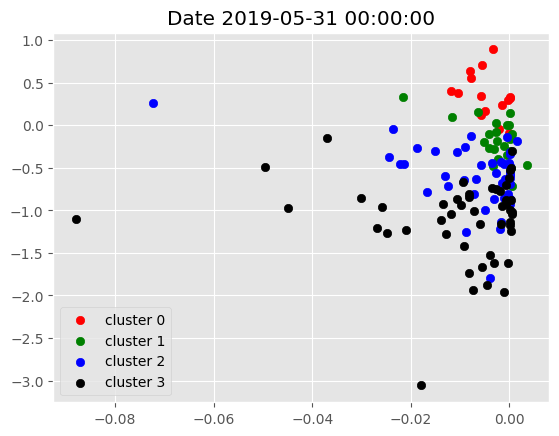

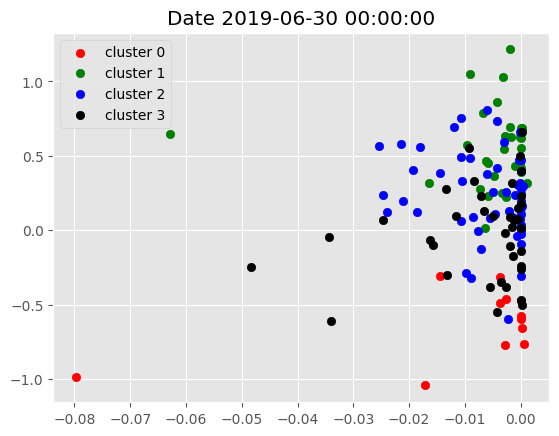

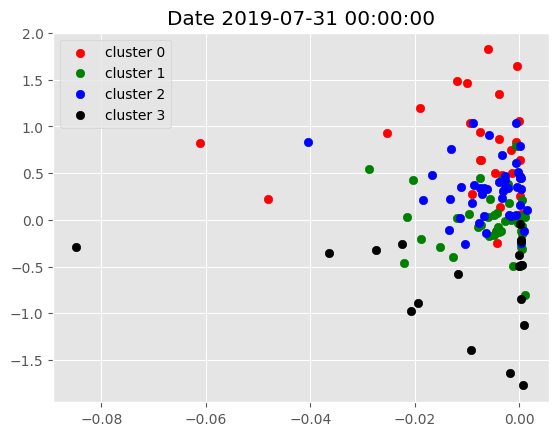

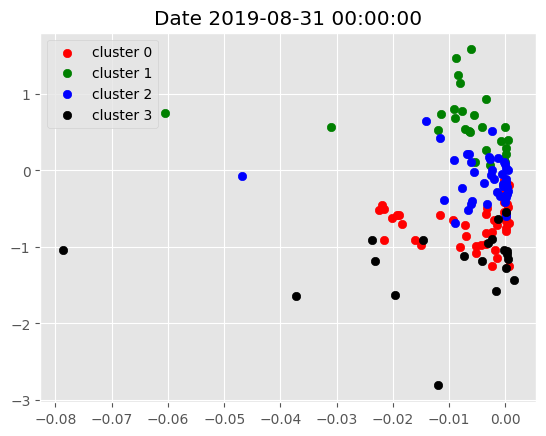

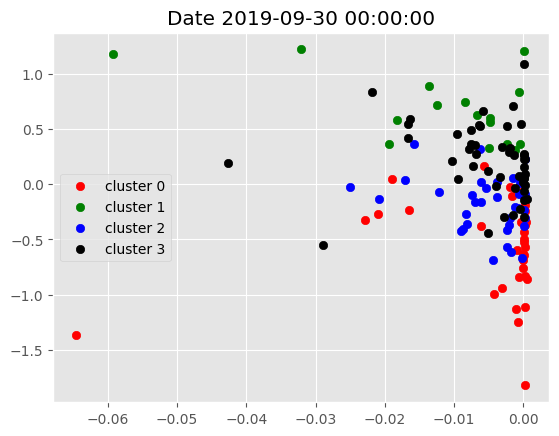

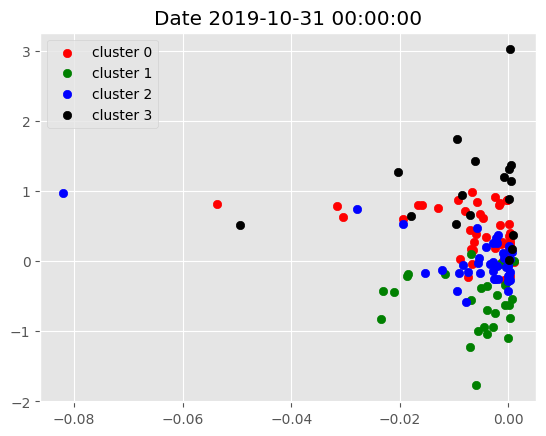

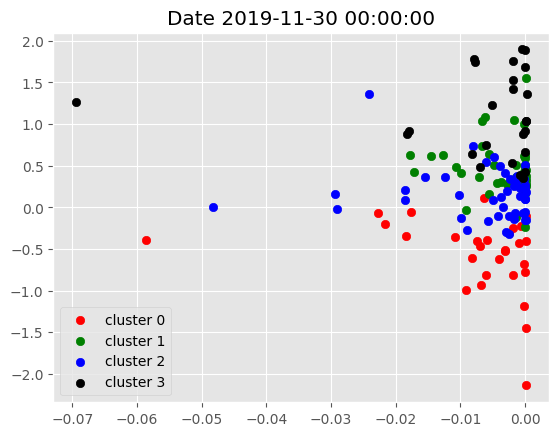

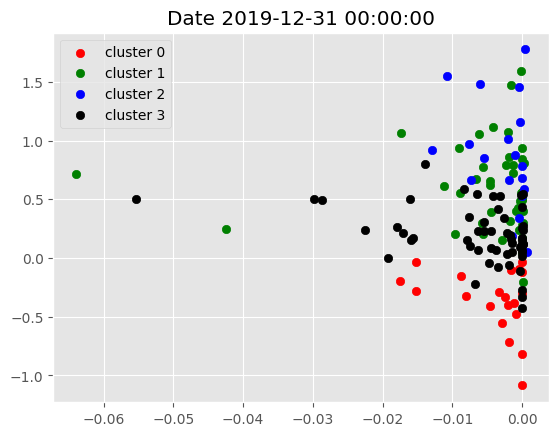

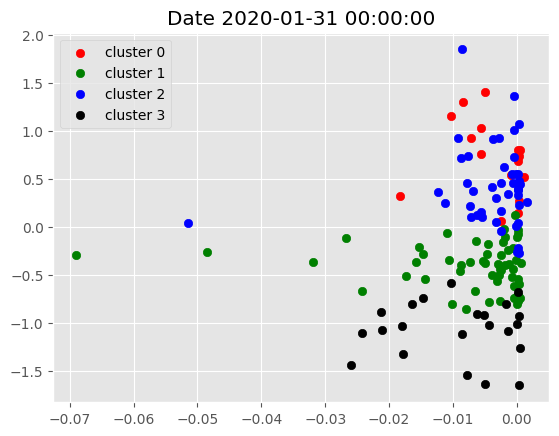

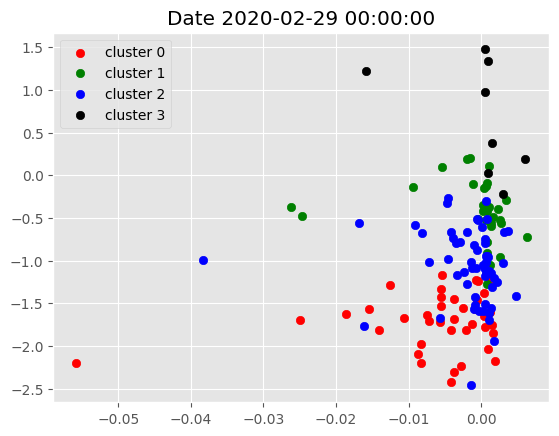

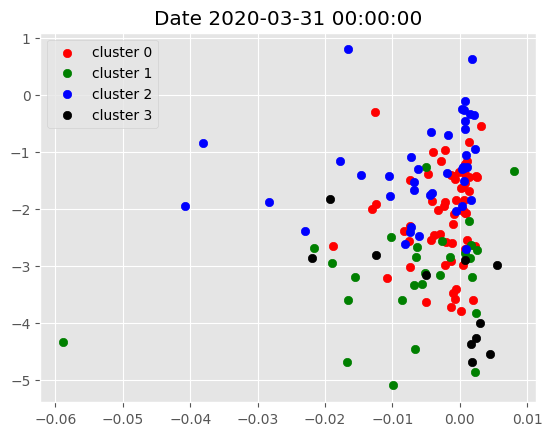

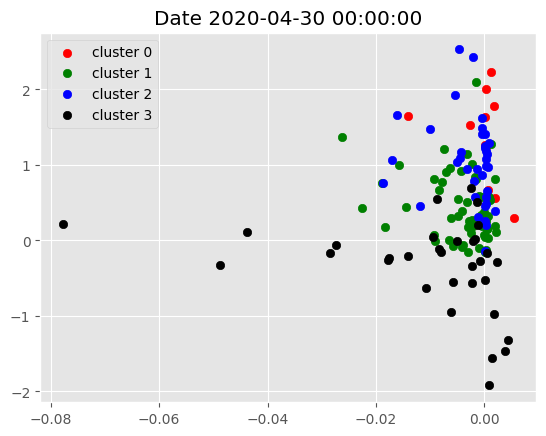

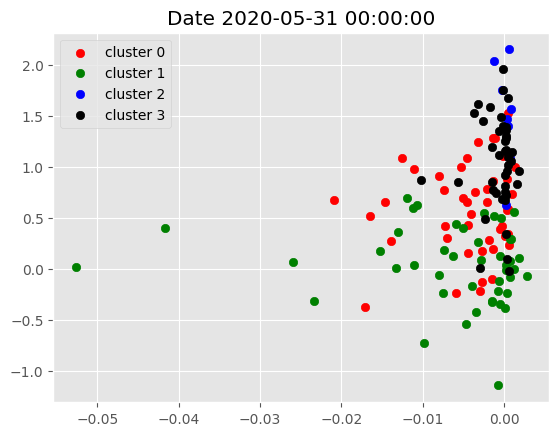

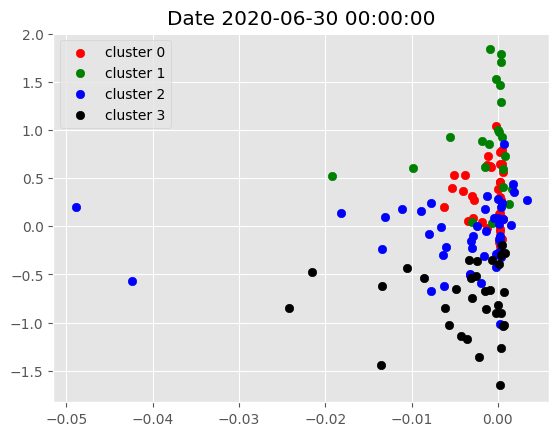

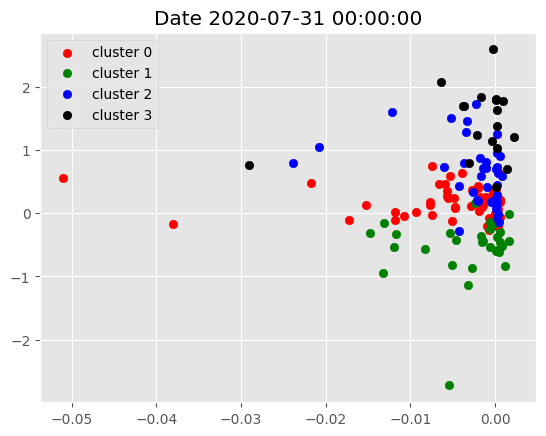

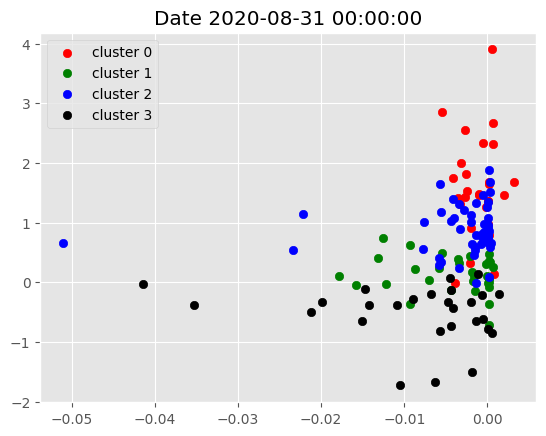

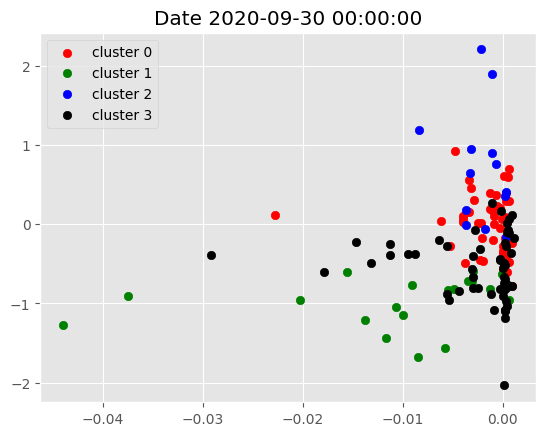

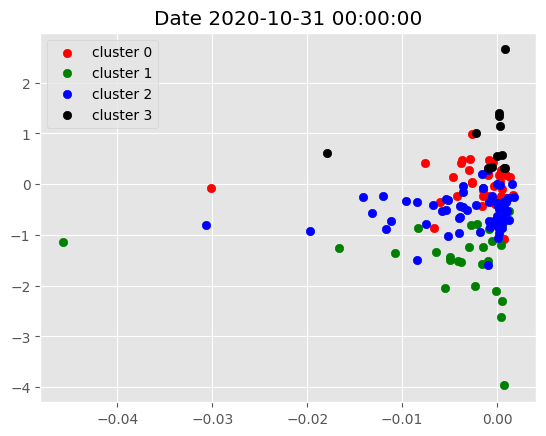

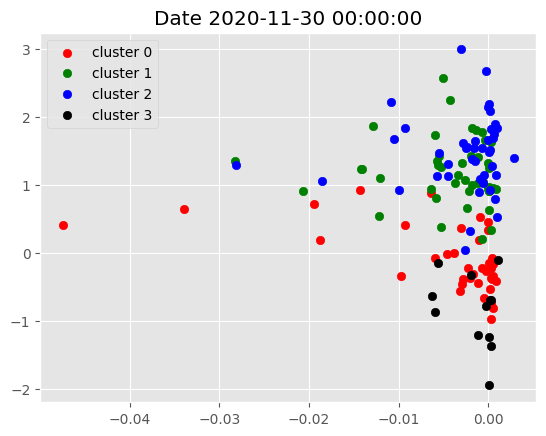

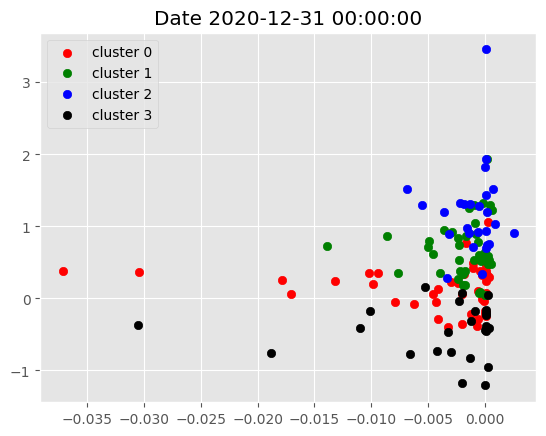

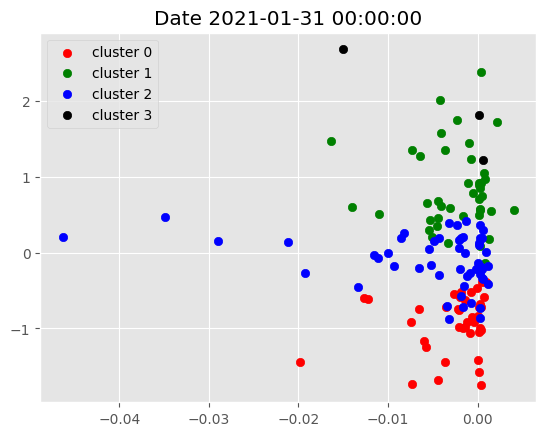

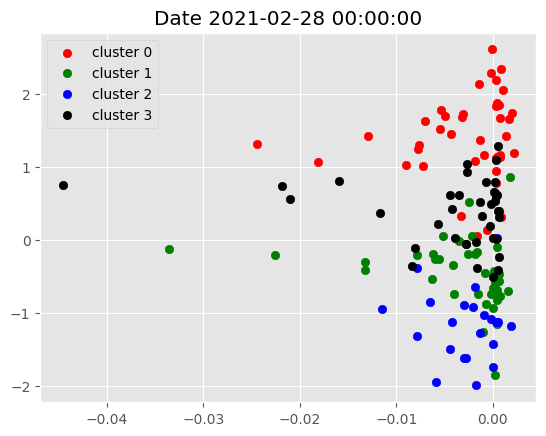

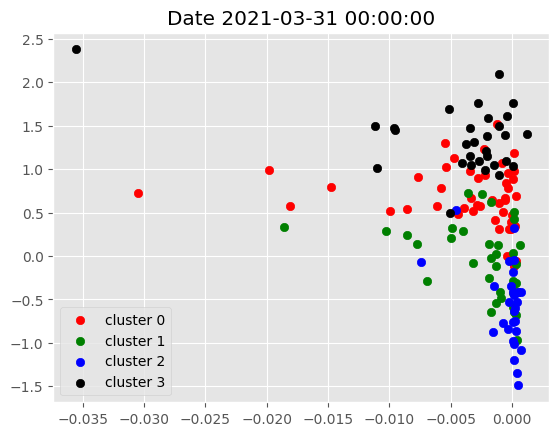

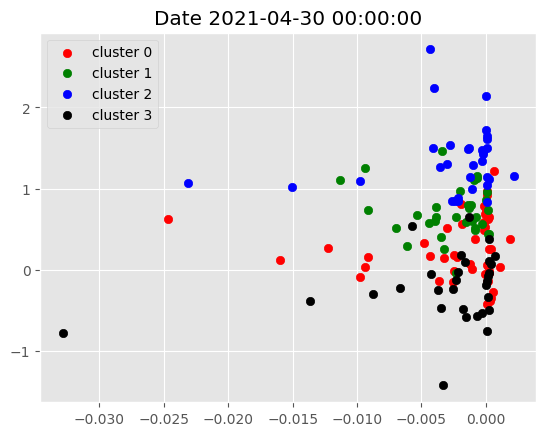

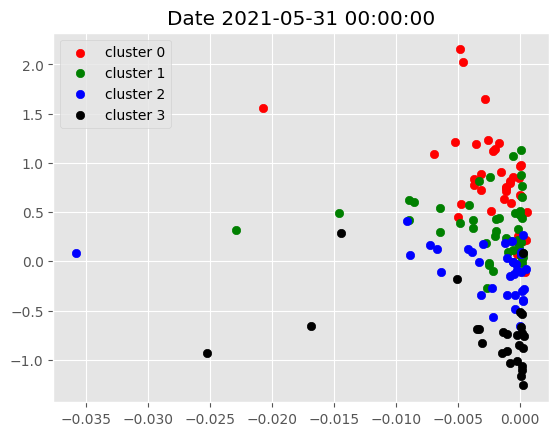

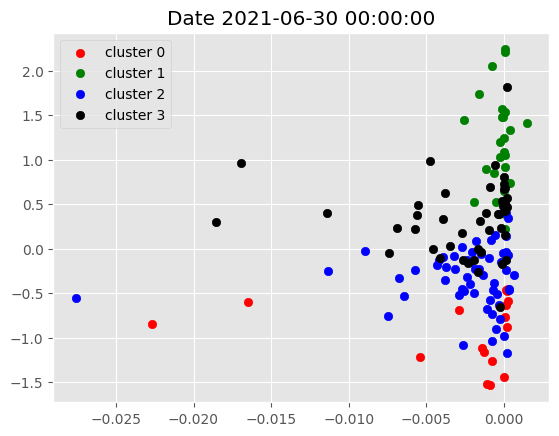

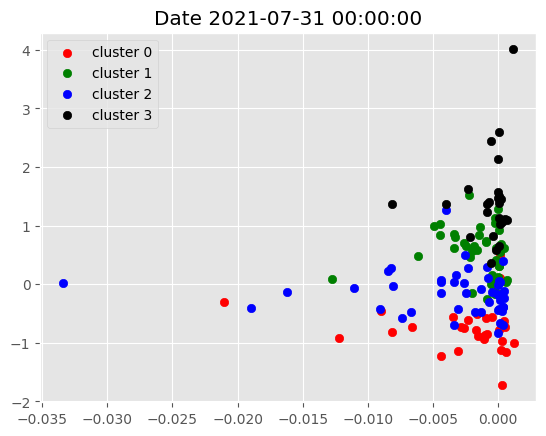

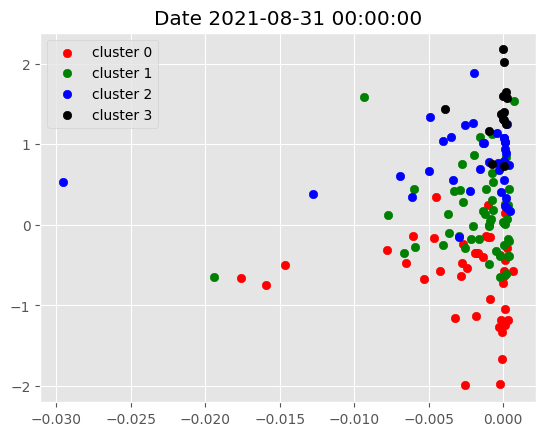

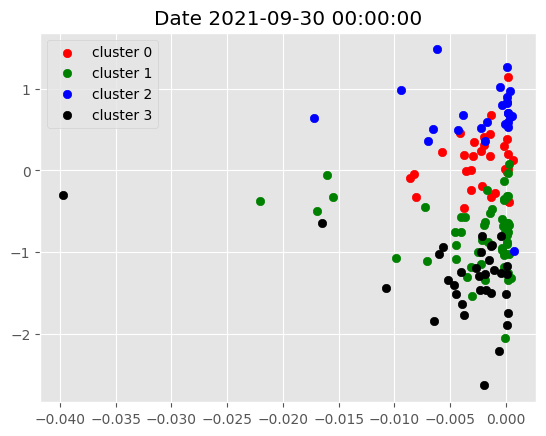

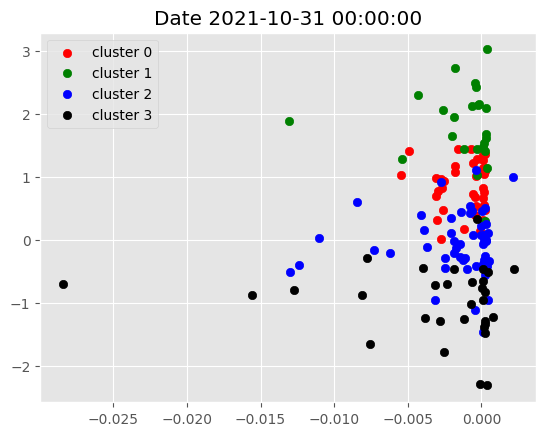

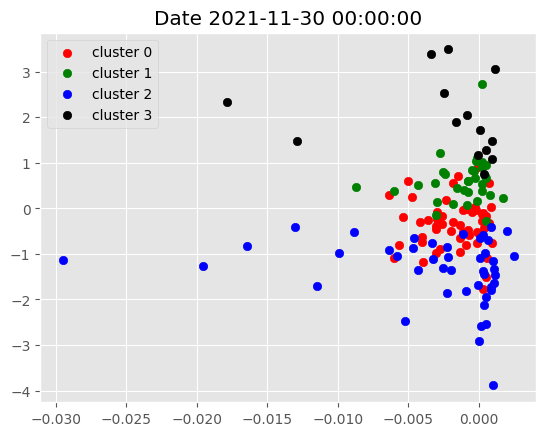

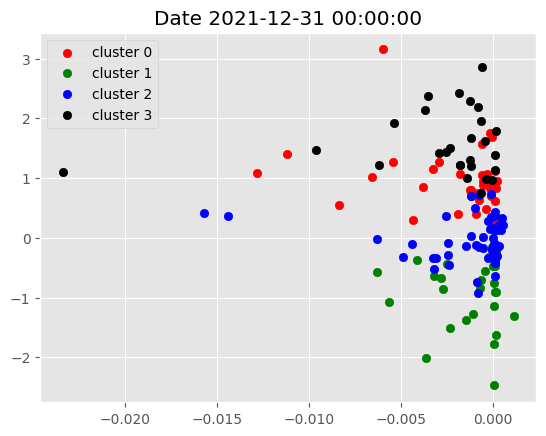

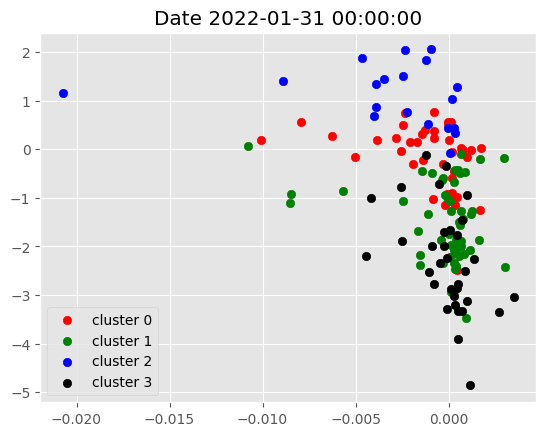

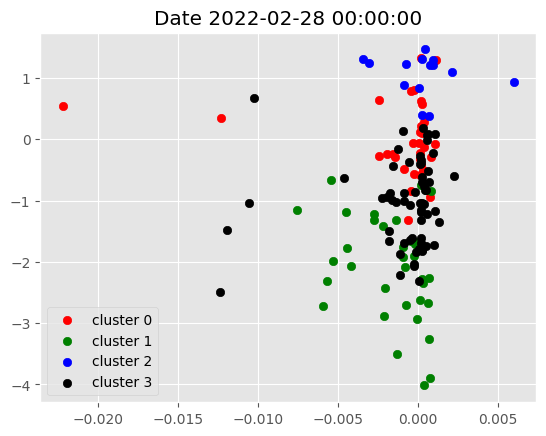

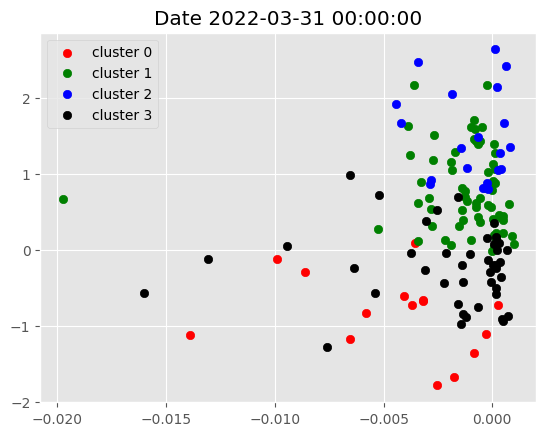

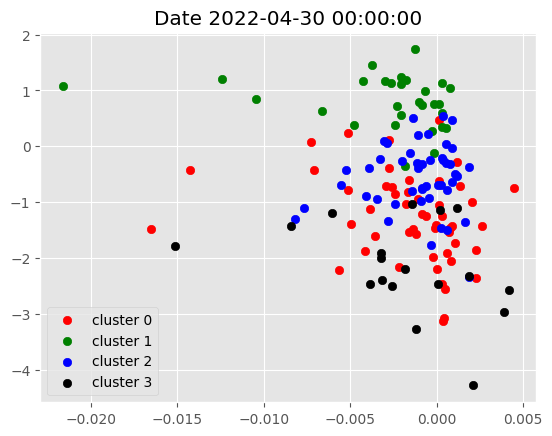

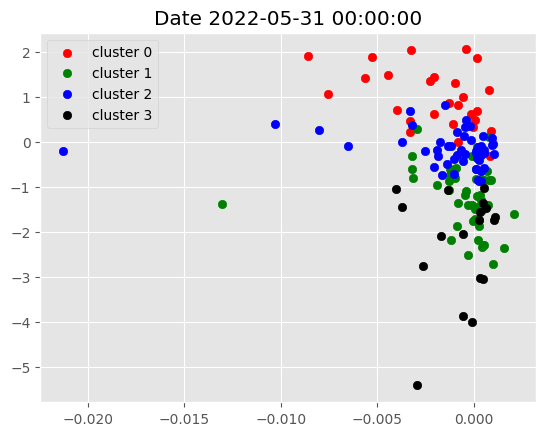

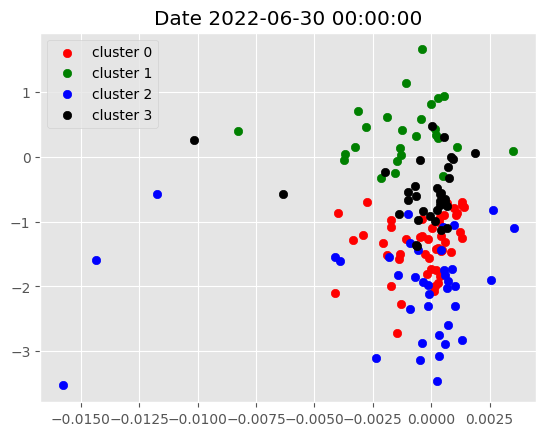

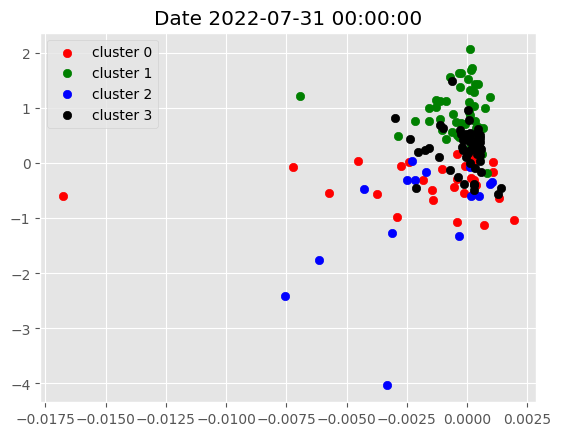

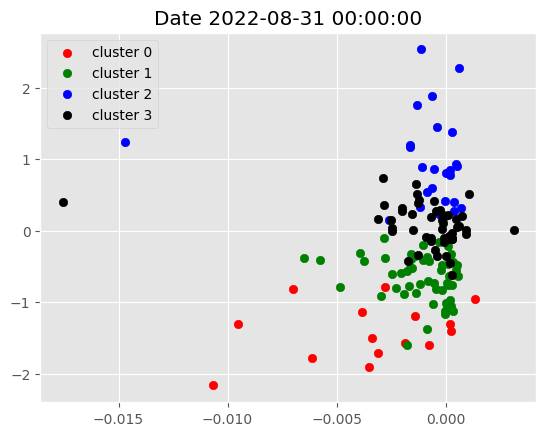

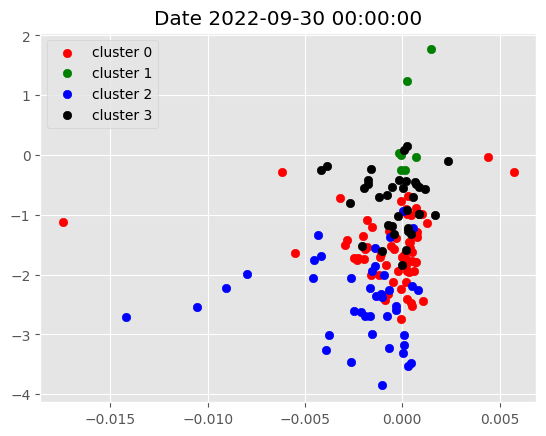

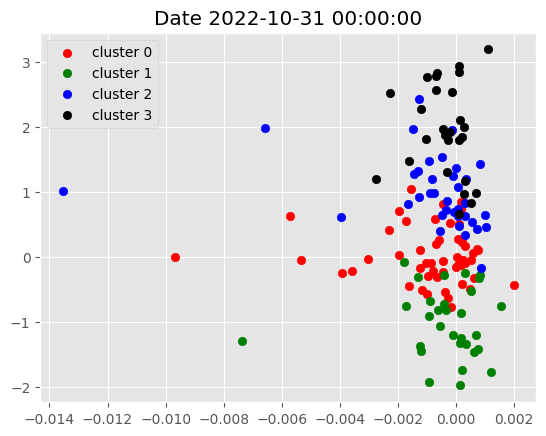

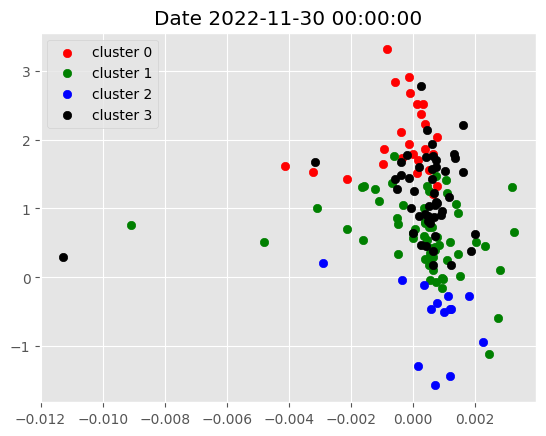

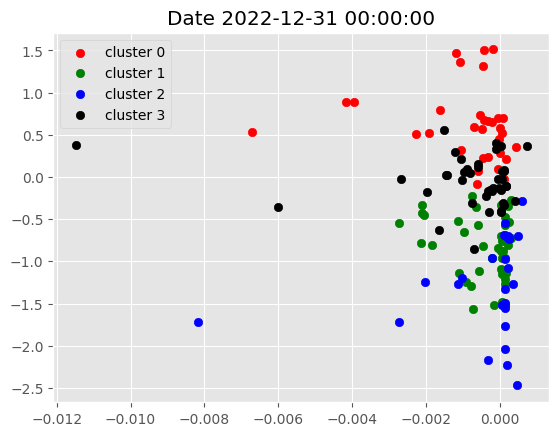

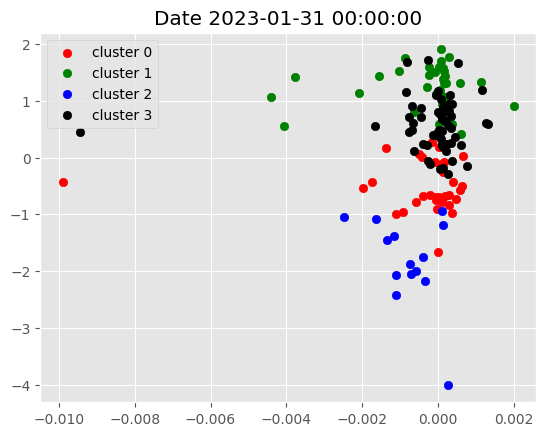

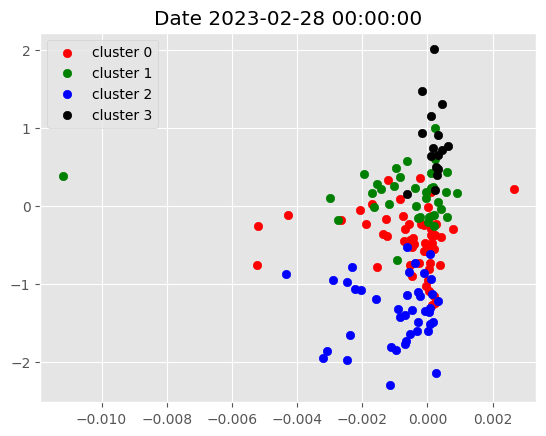

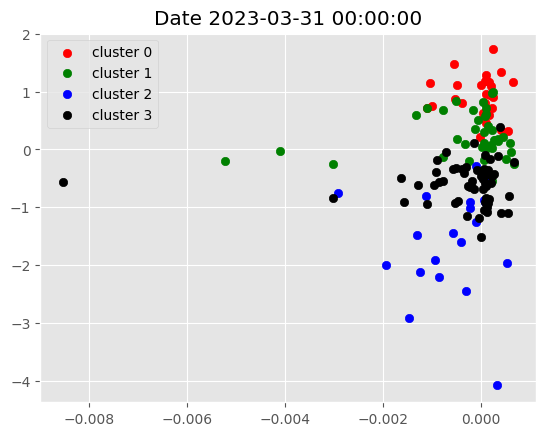

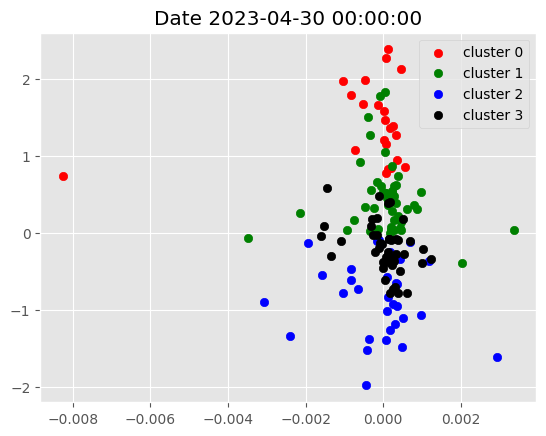

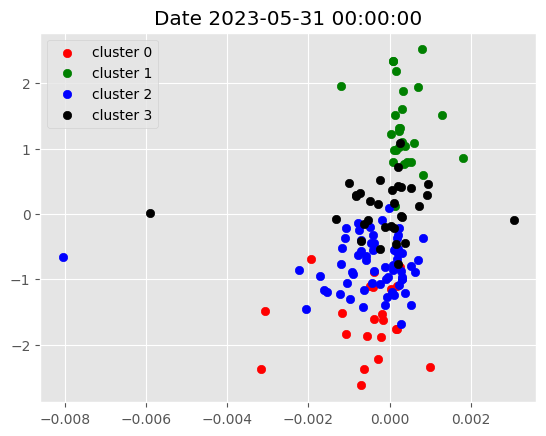

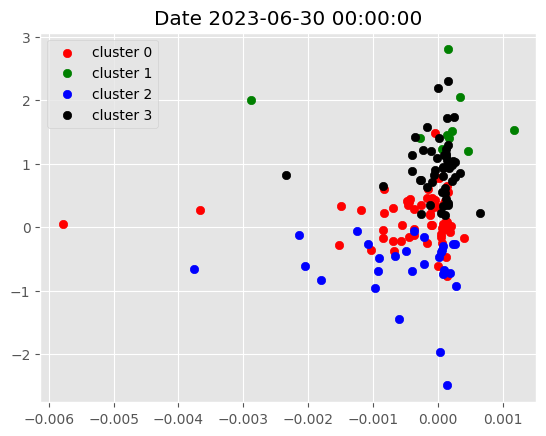

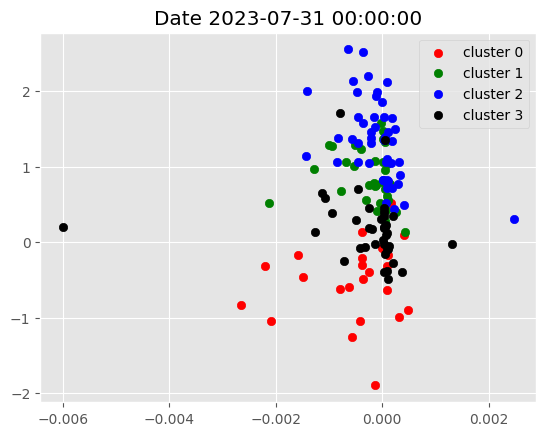

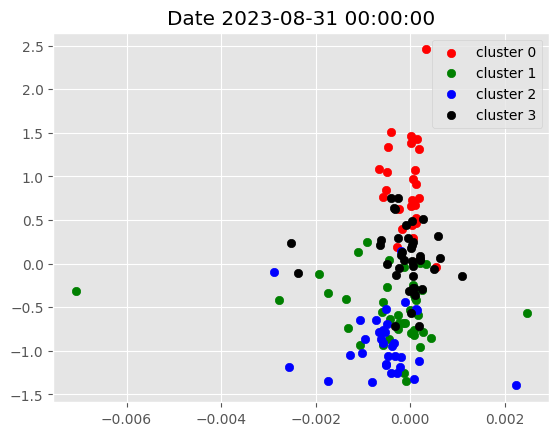

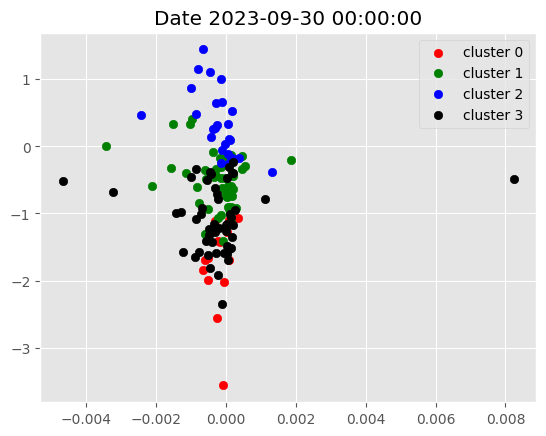

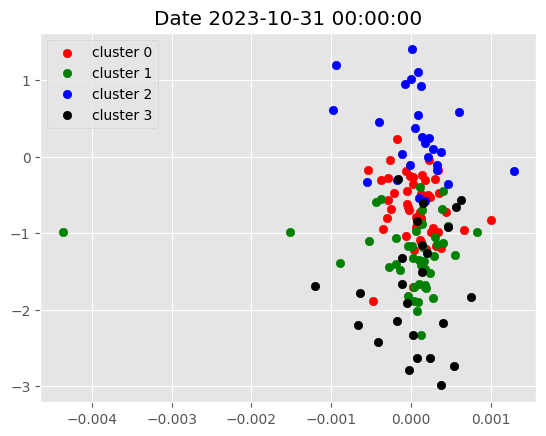

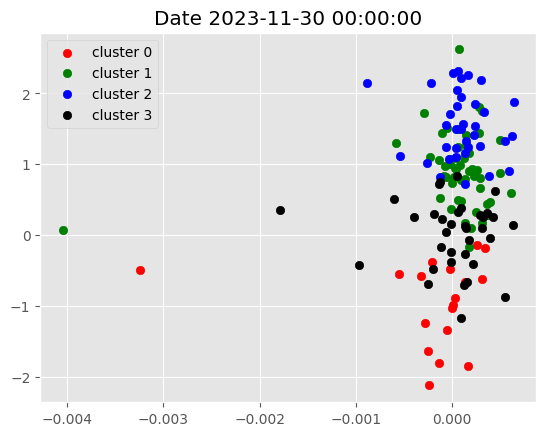

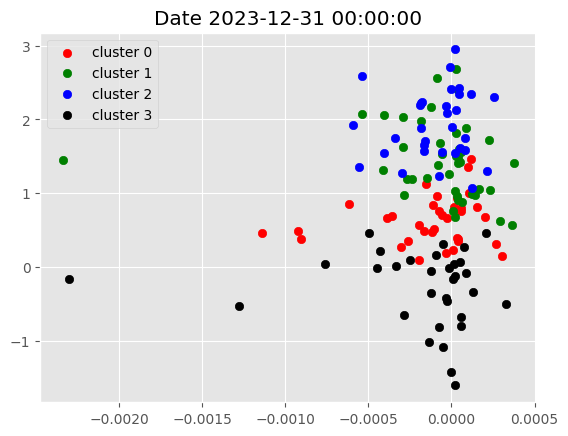

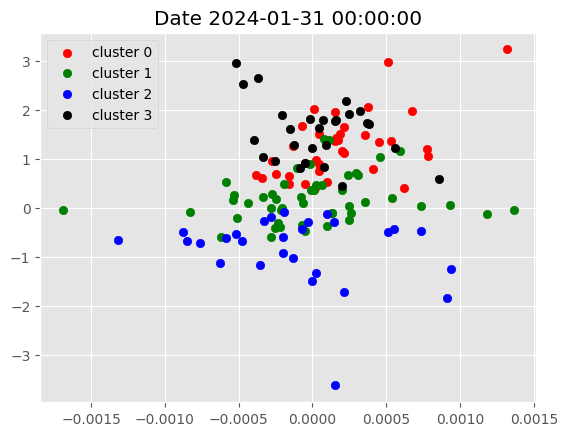

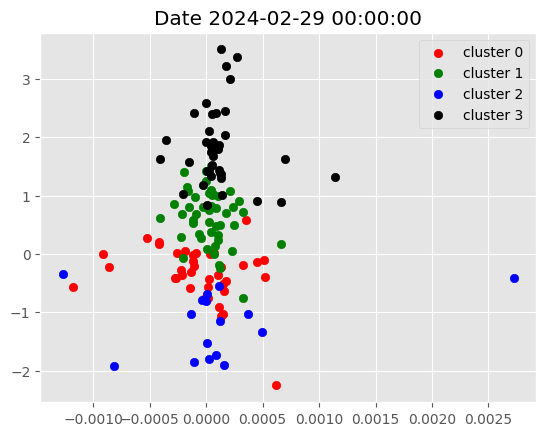

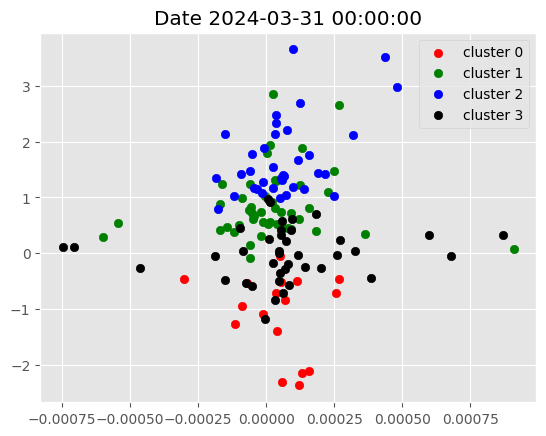

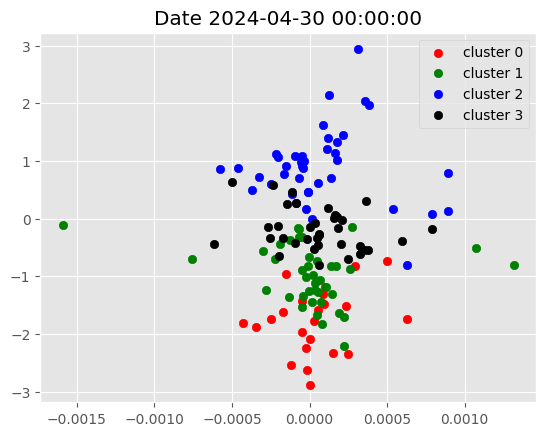

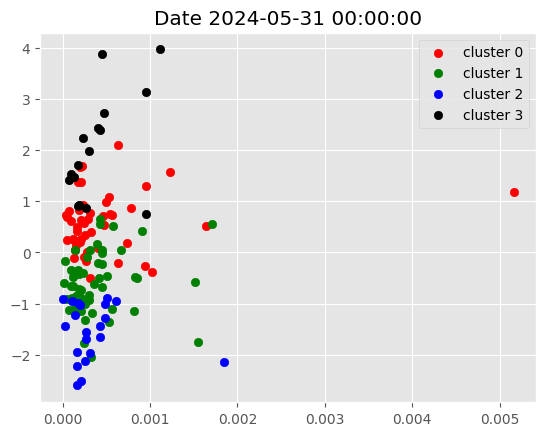

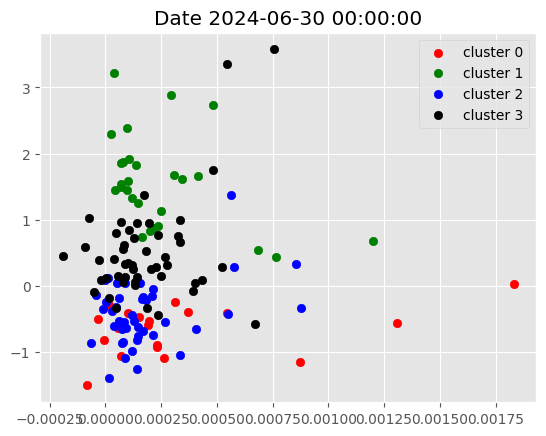

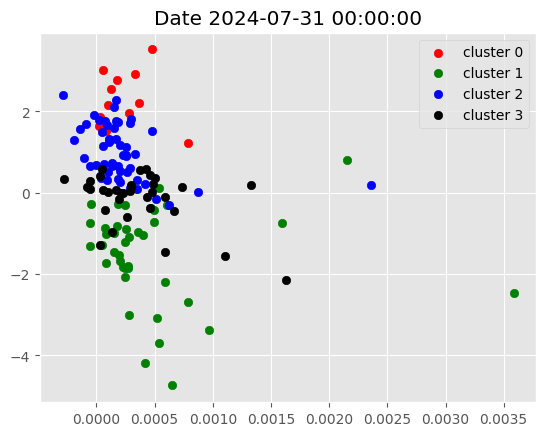

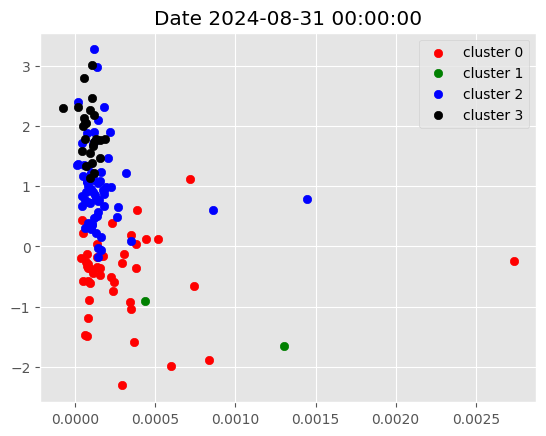

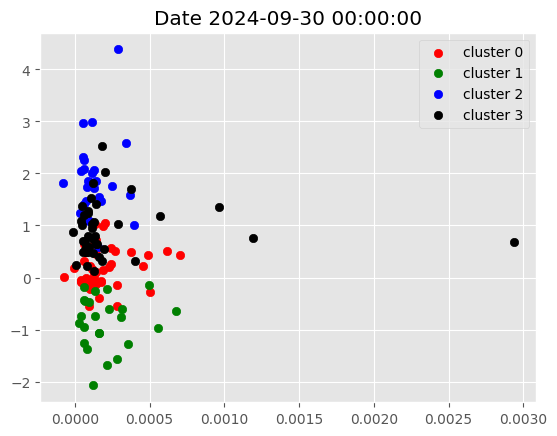

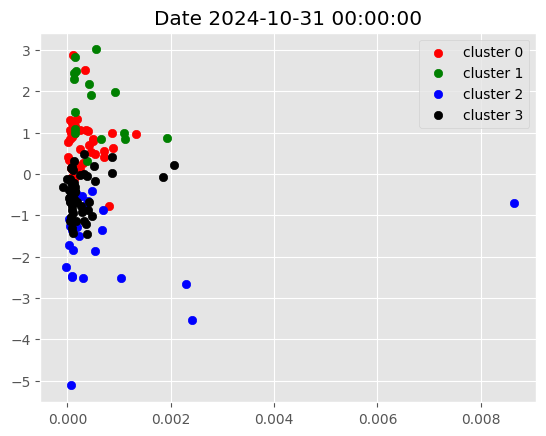

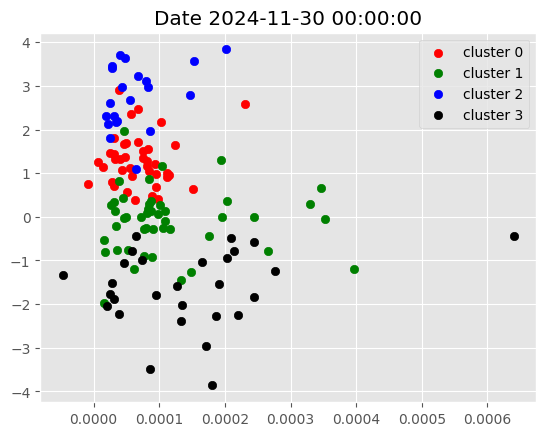

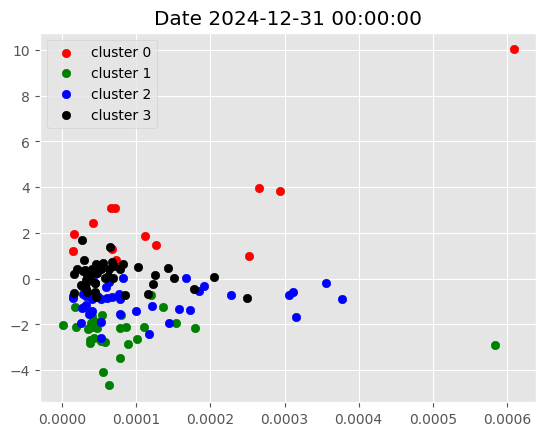

In [23]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### Apply pre-defined centroids.

In [24]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [25]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-02-01': ['ABT',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMZN',
  'AVGO',
  'BAC',
  'BKNG',
  'BLK',
  'CRM',
  'CSCO',
  'DE',
  'DLTR',
  'EA',
  'GILD',
  'GOOG',
  'GOOGL',
  'GS',
  'HD',
  'HON',
  'HUM',
  'INTU',
  'LLY',
  'MA',
  'MAR',
  'MMM',
  'MU',
  'NFLX',
  'NXPI',
  'ORCL',
  'PM',
  'SBUX',
  'SCHW',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'TMUS',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'USB',
  'VRTX',
  'WDC',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  'ORCL',
  'PANW',
  'PM',
  'PYPL',
  'TMO',
  'ULTA',
  'UNP',
  'V',
  'XOM'],
 '2019-04-01': ['BA',
  'BAC',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'CI',
  'COP',
  'CVS',
  'DD',
  'DIS',
  'ELV',
  'EXPE',
  'GM',
  'GS',
  'HUM',

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [29]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [30]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[**********************96%*********************  ]  147 of 153 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************99%***********************]  151 of 153 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-31   39.388077   83.089928   55.295002  144.842697  199.759995   
2018-02-01   39.470425   86.140457   55.312778  144.626373  199.380005   
2018-02-02   37.757790   85.274170   54.876904  141.417694  195.639999   
2018-02-05   36.814434   81.083397   52.243805  136.847946  190.270004   
2018-02-06   38.352985   82.334694   52.359444  139.425751  194.470001   
...                ...         ...         ...         ...         ...   
2024-12-23  255.270004  178.389999  114.309998  358.769989  446.739990   
2024-12-24  258.200012  180.000000  114.760002  361.630005  447.940002   
2024-12-26  259.019989  179.199997  115.269997  360.429993  450.160004   
2024-12-27  255.589996  178.009995  114.989998  356.179993  446.480011   
2024-12-30  251.789993  176.597305  113.430000  352.834991  441.915009   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-31   80.531418  106.708000  115.620003  262.000000   49.579910  ...   
2018-02-01   80.329842  103.937378  115.570000  255.570007   49.256344  ...   
2018-02-02   78.103561  102.340607  111.639999  257.380005   46.852688  ...   
2018-02-05   74.851814   98.456520  109.180000  242.399994   44.661667  ...   
2018-02-06   77.603973   97.489838  112.620003  241.449997   46.455170  ...   
...                ...         ...         ...         ...         ...  ...   
2024-12-23  214.889999  294.149994  297.489990  207.570007  167.460007  ...   
2024-12-24  218.089996  296.459991  301.230011  213.500000  168.369995  ...   
2024-12-26  218.059998  297.230011  300.279999  215.500000  167.550003  ...   
2024-12-27  216.990005  296.179993  297.589996  211.429993  166.830002  ...   
2024-12-30  212.740005  293.079987  293.200012  206.960007  162.199997  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC        WFC   
Date                                                                            
2018-01-31  5334000  2323800  17827000   6742400  1356100  8524300   18147900   
2018-02-01  5032300  5090000  18646100   5198400  1073200  3555200   15717600   
2018-02-02  4656700  3455100  15574000   7024800  1193900  5010400   18905300   
2018-02-05  7072900  2906900  22239600   7085900  1609800  5205200  103394400   
2018-02-06  6335000  3114600  34543900   6809100  2081400  4835800   83076900   
...             ...      ...       ...       ...      ...      ...        ...   
2024-12-23  2832600  2204300  21292300  18506100  3676000  4111200   11817000   
2024-12-24  1170100  1468600  11712200   8724500   850500  1512100    4442700   
2024-12-26  1884400  1191500  12946400  15705800  1243900  2146000    6964300   
2024-12-27  1697800  1373400  15142000  11610000  1602800  4161800    7219500   
2024-12-30    61741    82033   1010040    759127    30736   189060     215396   

Price                                     
Ticker           WMT      WYNN       XOM  
Date                                      
2018-01-31  29438400  11253100  14404700  
2018-02-01  19160400   6416100  17971000  
2018-02-02  27759300   5398800  29822100  
2018-02-05  37684800   4916800  30452700  
2018-02-06  49241400   3672700  36262800  
...              ...       ...       ...  
2024-12-23  26205400   1312400  12285100  
2024-12-24   8992400    692800   7807000  
2024-12-26  10994000   1218900   9652400  
2024-12-27  11376900   1086700  11933000  
2024-12-30    506020     70603    492532  

[1740 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [78]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the

""


## 8. Visualize Portfolio returns and compare to SP500 returns.